# Verschiedene Ansätze die verbessert / verworfen wurden

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from skimage import io
from scipy.signal import find_peaks, correlate2d


def show_image(img, cmap=None, name=None, size=None):
    if size is not None:
        plt.figure(figsize=size)
    else:
        plt.figure(figsize=(3,3))
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis('off')
    if name is not None:
        plt.title(name)
    plt.show()

image = io.imread('resources/aligned/shot_1.jpg')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## 1 Ring erkennung

### 1.1 Cv2 Hough Transform

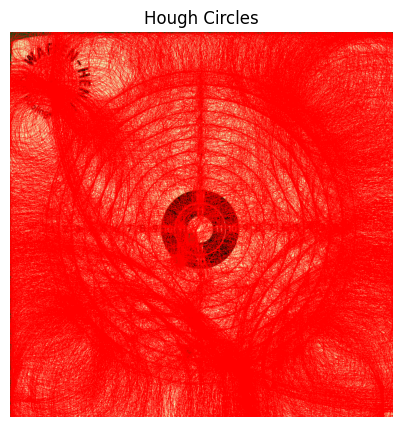

In [4]:
circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1, minDist=10, param1=150, param2=30, minRadius=0, maxRadius=0)
circles = np.round(circles[0, :]).astype("int")
marked = image.copy()
for (x, y, r) in circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 1)
show_image(marked, size=(5,5), name="Hough circles")

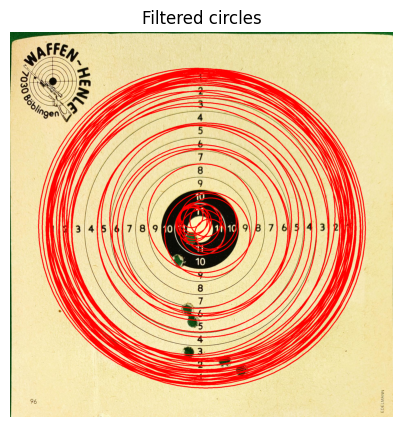

In [10]:
filtered_circles = []
height, width = image.shape[:2]
width = int(width/2)
height = int(height/2)
tollerance = 50
for (x, y, r) in circles:
    if (x > width - tollerance) and (x < width+tollerance) and (y > height-tollerance) and (y < height+tollerance):
        filtered_circles.append((x, y, r))

marked = image.copy()
for (x, y, r) in filtered_circles:
    output_1 = cv2.circle(marked, (x, y), r, (255, 0, 0), 3)
show_image(marked, size=(5, 5), name="Filtered circles")

Ungenau und sehr langsam

### 1.2 Mittelpunkt über größte Kontur bestimmen

Schritte:
1. Bild in Graubild konvertieren
2. Median Filter zum entfernen von Salt&Pepper
3. Kantenerkennung mithilfe von Sobel Filter oder Canny
4. Konturen finden
5. Nach Kontur suchen mit größtem Radius
6. Mittelpunkt bestimmten durch Zentrum des minimal umschließenden Kreis

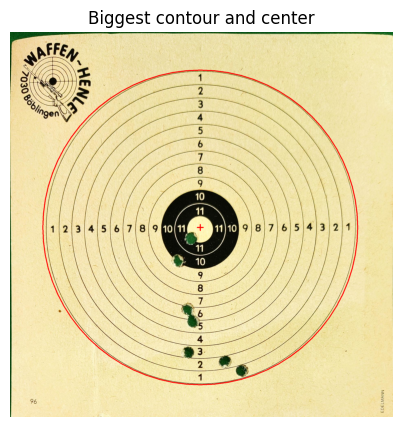

In [11]:
gray_image_blur = cv2.GaussianBlur(gray_image, (15,15), 0)
sobelx = cv2.Sobel(gray_image_blur, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image_blur, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# CV2 sobel ist deutlich schneller als selber geschriebener
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255

contours, _ = cv2.findContours(sobel, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
biggest_cntr = None
biggest_radius = 0
marked = image.copy()
for contour in contours:
    radius = cv2.minEnclosingCircle(contour)[1]
    area = cv2.contourArea(contour)
    total = area * radius
    if total > biggest_radius:
        biggest_radius = total
        biggest_cntr = contour

# Zentrum der größten Kontur über minimal umschließenden Kreis
(centerX, centerY), biggest_radius = cv2.minEnclosingCircle(biggest_cntr)
centerX = int(centerX)
centerY = int(centerY)

cv2.drawMarker(marked, (centerX, centerY), (255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=30, thickness=3, line_type=cv2.LINE_AA)
cv2.circle(marked, (centerX, centerY), int(biggest_radius), (255, 0, 0), 3)
show_image(marked, size=(5,5), name="Biggest contour and center")

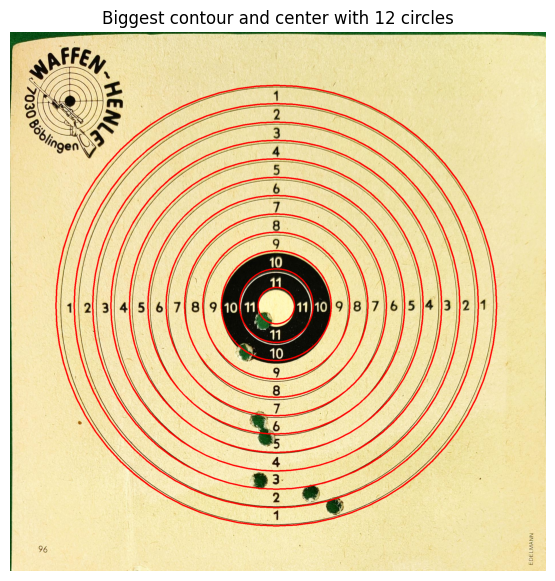

In [12]:
marked = image.copy()
for i in range(1, 13):
    cv2.circle(marked, (centerX, centerY), int(biggest_radius * i / 12), (255, 0, 0), 3)
show_image(marked, size=(7,7), name="Biggest contour and center with 12 circles")

Sehr schnell aber man müsste für verschiedene Zielscheiben übergeben wie viele Kreise es hat und minimal Umschließender Kreis ist nicht perfekt. Bild müsste perfekt aufgenommen sein sonst ist der Mittelpunkt nicht genau richtig

## 2 Schusserkennung

### 2.1 Template matching

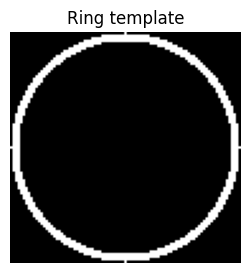

In [21]:
def create_binary_ring(inner_radius, outer_radius):    
    template = []

    for i in range(-outer_radius, outer_radius + 1):
        row = []
        for j in range(-outer_radius, outer_radius + 1):
            distance = (i ** 2 + j ** 2) ** 0.5
            if inner_radius <= distance <= outer_radius:
                row.append(1)
            else:
                row.append(0)
        template.append(row)

    return template

ring_template = create_binary_ring(42, 45)
show_image(ring_template, cmap='gray', name="Ring template")

sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# Normalize and threshold the result
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
threshold = 40
sobel[sobel < threshold] = 0
sobel[sobel >= threshold] = 255


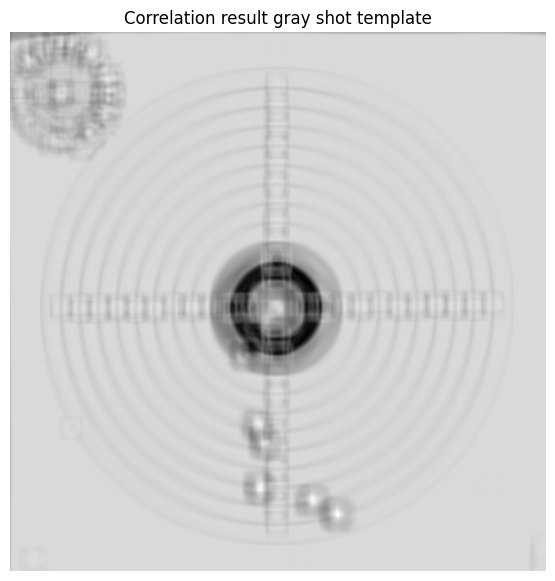

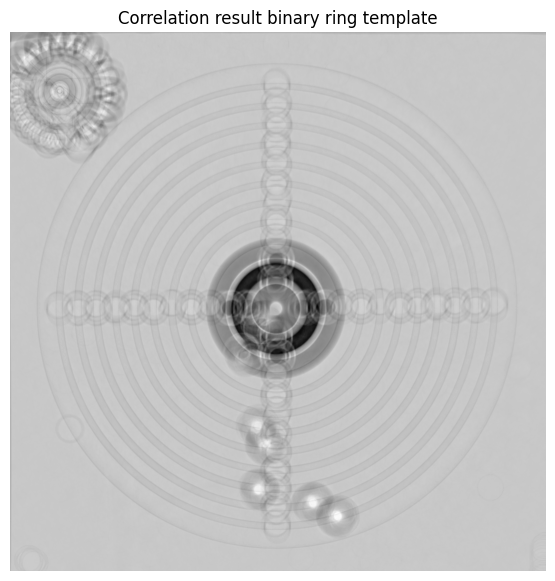

In [25]:
template_2 = cv2.imread('resources/shots/gray_hole.jpg', cv2.IMREAD_GRAYSCALE)
ring_template_uint8 = np.array(ring_template, dtype=np.uint8)
template_2 = np.array(template_2, dtype=np.uint8)


result_binary_template_2 = cv2.matchTemplate(binary, template_2, cv2.TM_CCORR_NORMED)
show_image(result_binary_template_2, cmap='gray', size=(7,7), name="Correlation result gray shot template")

result_binary_gray = cv2.matchTemplate(gray_image, ring_template_uint8, cv2.TM_CCORR_NORMED)
show_image(result_binary_gray, cmap='gray', size=(7,7), name="Correlation result binary ring template")

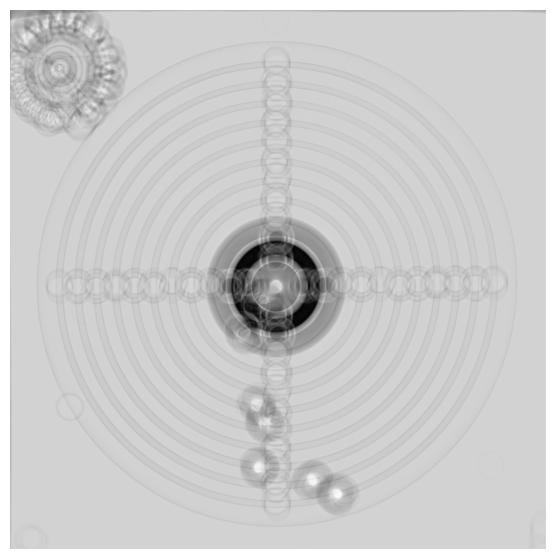

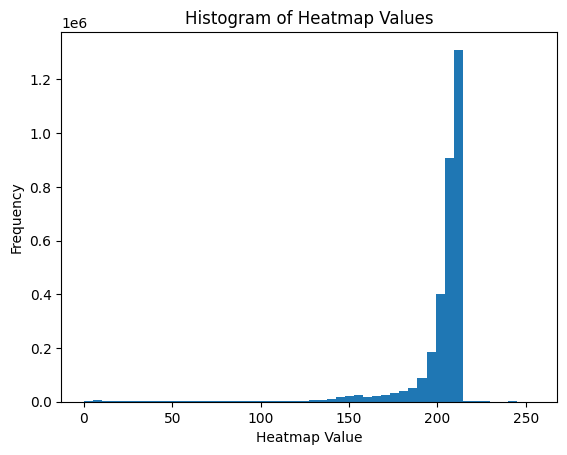

2529606


KeyboardInterrupt: 

In [27]:
heatmap = cv2.normalize(result_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
show_image(heatmap, cmap='gray', size=(7,7))
hist, bins = np.histogram(heatmap.flatten(), bins=50)

# Plot the histogram
plt.hist(heatmap.flatten(), bins=50)
plt.xlabel('Heatmap Value')
plt.ylabel('Frequency')
plt.title('Histogram of Heatmap Values')
plt.show()

heatmap = cv2.medianBlur(heatmap, 3)
heatmap = cv2.GaussianBlur(heatmap, (3, 3), 0)

threshold = 0.8
peaks = np.argwhere(heatmap >= threshold * np.max(heatmap))

# Filter out the peaks that are too close to each other
filtered_peaks = []
for peak in peaks:
    if all(np.linalg.norm(np.array(peak) - np.array(filtered_peak)) > 10 for filtered_peak in filtered_peaks):
        filtered_peaks.append(peak)

# Draw circles around the filtered peaks
for peak in filtered_peaks:
    cv2.circle(image, tuple(peak[::-1]), 10, (0, 0, 255), 2)

show_image(image, size=(7,7))